In [ ]:
# In this Notebook we are trying to understand how google translare works.
# The objective is to convert a German sentence to its English counterpart using a Neural Machine Translation (NMT) system

In [24]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [25]:
# function to read raw text file
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')
        
        # read all text
        text = file.read()
        file.close()
        return text

In [26]:
# split a text into sentences
def to_lines(text):
      sents = text.strip().split('\n')
      sents = [i.split('\t') for i in sents]
      return sents

In [27]:
data = read_text("deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [28]:
deu_eng = deu_eng[:50000,:]

In [29]:
deu_eng

array([['Hi.', 'Hallo!'],
       ['Hi.', 'Grüß Gott!'],
       ['Run!', 'Lauf!'],
       ...,
       ['Mary has very long hair.', 'Maria hat sehr langes Haar.'],
       ["Mary is Tom's secretary.", 'Maria ist Toms Sekretärin.'],
       ['Mary is a married woman.', 'Maria ist eine verheiratete Frau.']],
      dtype='<U380')

In [30]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

deu_eng

array([['Hi', 'Hallo'],
       ['Hi', 'Grüß Gott'],
       ['Run', 'Lauf'],
       ...,
       ['Mary has very long hair', 'Maria hat sehr langes Haar'],
       ['Mary is Toms secretary', 'Maria ist Toms Sekretärin'],
       ['Mary is a married woman', 'Maria ist eine verheiratete Frau']],
      dtype='<U380')

In [31]:
# convert text to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

deu_eng

array([['hi', 'hallo'],
       ['hi', 'grüß gott'],
       ['run', 'lauf'],
       ...,
       ['mary has very long hair', 'maria hat sehr langes haar'],
       ['mary is toms secretary', 'maria ist toms sekretärin'],
       ['mary is a married woman', 'maria ist eine verheiratete frau']],
      dtype='<U380')

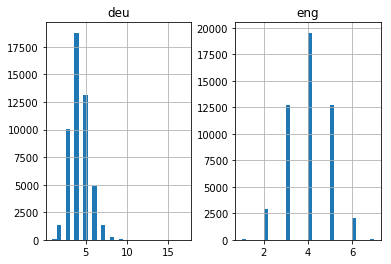

In [32]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
      eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
      deu_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

length_df.hist(bins = 30)
plt.show()

In [33]:
# function to build a tokenizer
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [34]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6453


In [35]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10998


In [36]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
         # integer encode sequences
         seq = tokenizer.texts_to_sequences(lines)
         # pad sequences with 0 values
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq

In [37]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [38]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [39]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences=True))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

In [40]:
# model compilation
model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)

In [41]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [42]:
filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

Train on 32000 samples, validate on 8000 samples
Epoch 1/30
32000/32000 [==============================] - 620s 19ms/step - loss: 3.6220 - val_loss: 3.0565

Epoch 00001: val_loss improved from inf to 3.05649, saving model to model.h1.24_jan_19
Epoch 2/30
32000/32000 [==============================] - 663s 21ms/step - loss: 2.9781 - val_loss: 2.9904

Epoch 00002: val_loss improved from 3.05649 to 2.99039, saving model to model.h1.24_jan_19
Epoch 3/30
32000/32000 [==============================] - 689s 22ms/step - loss: 2.8085 - val_loss: 2.7635

Epoch 00003: val_loss improved from 2.99039 to 2.76351, saving model to model.h1.24_jan_19
Epoch 4/30
32000/32000 [==============================] - 835s 26ms/step - loss: 2.6315 - val_loss: 2.6623

Epoch 00004: val_loss improved from 2.76351 to 2.66226, saving model to model.h1.24_jan_19
Epoch 5/30
32000/32000 [==============================] - 979s 31ms/step - loss: 2.4898 - val_loss: 2.5484

Epoch 00005: val_loss improved from 2.66226 to 2.54

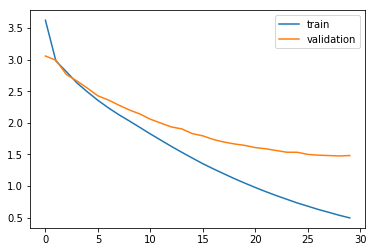

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [44]:
model = load_model('model.h1.24_jan_19')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [45]:
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

In [46]:
preds_text = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], eng_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))

In [47]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [48]:
# print 15 rows randomly
pred_df.sample(15)

,actual,predicted
6140,come sit by me,come and with me
5802,tom was thirty,tom was humiliated
8489,keep the change,is that right
5619,tom understands french,tom understands french
8406,did you see it,did you seen it
4183,its still light out,its is
3448,that was great,that was great
125,she cant stop talking,she cant stop to
4295,you are a bad person,youre a bad liar
1408,its hot today,its warm today
